In [2]:
import argparse 
import cv2
import numpy as np
import os
import glob
import random
import Utility
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
from keras.models import * 
from keras.layers import *

import numpy as np
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from scipy.misc import imresize
import itertools

from sklearn.cross_validation import train_test_split 
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the training data 

In [4]:
trainList = ["Others\others","Melanoma\melanoma1","Melanoma\melanoma2","Melanoma\melanoma3","Melanoma\melanoma4"]
class_id = 0
class_path = []
segs_path = []
classes = []
imgs_path = []
paths = []
Melanoma = []
for training_name in trainList:
    class_path = Utility.imlist(training_name)
    paths += class_path
    classes += [class_id] * len(class_path)
    class_id += 1
    if(class_id>1):
        class_id=1
    
    

# Loading the segmented image data

In [5]:
path = "Ground_truth\\gt"
gt_paths = []
for pt in paths:
    #print(pt)
    newfile = pt.split("\\")[-1][0:-4]+ "_segmentation.png"
    newpath = path+"\\" + newfile
    #print (newpath)
    gt_paths.append(newpath)
    

In [6]:
len(gt_paths)

3122

In [7]:
#for data augmentation
import shutil
for pt in range(0,1626):
    shutil.copy(gt_paths[pt],"GT\\non_can")

In [8]:
#Melanoma Data is rotated along all the 4 directions 
path = ["GT\\non_can","GT\\gt1","GT\\gt2","GT\\gt3","GT\\gt4"]
gt_paths = []

i = 0
j = 0 
for pt in paths:
    #print(pt)
    newfile = pt.split("\\")[-1][0:-4]+ "_segmentation.png"
    
    if(j==1626 or j == 2000 or j==2374 or j == 2748):
        i = i + 1 
    j = j + 1    
    newpath = path[i] +"\\" + newfile
    
    #print (newpath)
    gt_paths.append(newpath)

In [9]:
norm_images = []
seg_images = []
for i in range(len(paths)):
    im = cv2.imread(paths[i])
    seg = cv2.imread(gt_paths[i],0)
    norm_images.append(im)
    seg_images.append(seg)

# Get the new segmented images

In [10]:
segmented = []

for i in range(len(norm_images)):
    img1 = cv2.resize(norm_images[i], (128,128))
    img2 = cv2.resize(seg_images[i], (128,128))
    
    #print(img1.shape)
    #print(img2.shape)
    B,G,R = cv2.split(img1)
    maskB = np.multiply(B,img2)
    maskG = np.multiply(G,img2)
    maskR = np.multiply(R,img2)
    img = cv2.merge((maskB,maskG,maskR))
    segmented.append(img)


In [11]:
segemented = np.array(segmented)
norm_images = np.array(norm_images)
seg_images = np.array(seg_images)

In [69]:
np.save("segemneted.npy",segemented)
np.save("norm_images.npy",norm_images)
np.save("seg_images.npy",seg_images)

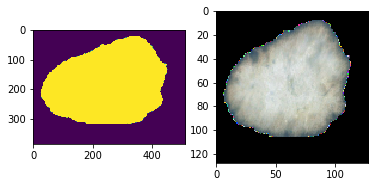

In [13]:
plt.subplot(1,2,1)
plt.imshow(seg_images[0])

plt.subplot(1,2,2)
plt.imshow(segemented[0])

# Divide data into testing and training

In [214]:
other_seg = segemented[0:1326]
mela_seg = segemented[1626:1950]
mela_seg2 = segemented[2000:2324]
mela_seg3 = segemented[2374:2698]
mela_seg4 = segemented[2748:3072]
x_train = np.concatenate((other_seg,mela_seg,mela_seg2,mela_seg3,mela_seg4),axis=0)

In [216]:
other_segt = segemented[1326:1626]
mela_segt = segemented[1950:2000]
mela_seg2t = segemented[2324:2374]
mela_seg3t = segemented[2698:2748]
mela_seg4t = segemented[3072:3122]


x_test = np.concatenate((other_segt,mela_segt,mela_seg2t,mela_seg3t,mela_seg4t),axis=0)

In [217]:
x_test.shape

(500, 128, 128, 3)

In [218]:
y_train = np.concatenate((classes[:1326],classes[1626:1950],classes[2000:2324],classes[2374:2698],classes[2748:3072]),axis=0)
y_test = np.concatenate((classes[1326:1626],classes[1950:2000],classes[2324:2374],classes[2698:2748],classes[3072:3122]),axis=0)

In [219]:
y_test.shape

(500,)

In [220]:
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

y_train = LabelEncoder().fit_transform(y_train)
y_train = np_utils.to_categorical(y_train)
y_test = LabelEncoder().fit_transform(y_test)
y_test = np_utils.to_categorical(y_test)

In [221]:
y_test.shape

(500, 2)

# Build  a Keras model with 6 Layers

In [222]:
Optimizer=Adam(lr=0.001)
objective='binary_crossentropy'
def center_normalize(x):
    return (x-K.mean(x))/K.std(x)
model=Sequential()
#input layer
model.add(Activation(activation=center_normalize, input_shape=(128, 128,3)))
# convolutional layer
model.add(Convolution2D(32,5,5,border_mode='same',activation='relu',dim_ordering='tf'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2),dim_ordering='tf'))
# convolutional layer
model.add(Convolution2D(64,3,3,border_mode='same',activation='relu',dim_ordering='tf'))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2),dim_ordering='tf'))
model.add(Flatten())
# Relu 
model.add(Dense(128, activation='relu'))
# Sigmoid Fully connected layer
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss=objective,optimizer=Optimizer,metrics=['accuracy',precision,recall,fmeasure])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same", data_format="channels_last")`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same", data_format="channels_last")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  from ipykernel import kernelapp as app


In [223]:
model.fit(x_train,y_train,batch_size=100,nb_epoch=25,verbose=1)


C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/25
2622/2622 [==============================] - 256s 98ms/step - loss: 0.9373 - acc: 0.5849 - precision: 0.5873 - recall: 0.6098 - fmeasure: 0.5865
Epoch 2/25
2622/2622 [==============================] - 173s 66ms/step - loss: 0.6215 - acc: 0.6630 - precision: 0.6673 - recall: 0.6503 - fmeasure: 0.6583
Epoch 3/25
2622/2622 [==============================] - 173s 66ms/step - loss: 0.5889 - acc: 0.6901 - precision: 0.6936 - recall: 0.6834 - fmeasure: 0.6876
Epoch 4/25
2622/2622 [==============================] - 204s 78ms/step - loss: 0.5497 - acc: 0.7265 - precision: 0.7268 - recall: 0.7265 - fmeasure: 0.7264
Epoch 5/25
2622/2622 [==============================] - 181s 69ms/step - loss: 0.4953 - acc: 0.7637 - precision: 0.7647 - recall: 0.7628 - fmeasure: 0.7636
Epoch 6/25
2622/2622 [==============================] - 211s 80ms/step - loss: 0.4608 - acc: 0.7815 - precision: 0.7816 - recall: 0.7818 - fmeasure: 0.7813
Epoch 7/25
2622/2622 [==============================] - 202s 77m

In [224]:
from sklearn.metrics import classification_report
Y_test = np.argmax(y_test,axis=1)

In [225]:
y_pred = model.predict_classes(x_test)

In [226]:
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,

# Final Classification Result

In [227]:
print(classification_report(Y_test,y_pred))

             precision    recall  f1-score   support

          0       0.75      0.64      0.69       300
          1       0.56      0.69      0.62       200

avg / total       0.68      0.66      0.66       500



In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_7 (Activation)    (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2097280   
__________

In [18]:
def precision(y_true, y_pred) :
    """
   Precision metric.
   Only computes a batch-wise average of precision.
   Computes the precision, a metric for multi-label classification of
   how many selected items are relevant.
   """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [19]:
def recall(y_true, y_pred) :
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
     """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [20]:
def fmeasure(y_true, y_pred):
    """
    Computes the f-score, the harmonic mean of precision and recall
    
    Here it is only computed batch-wise, not globally
    
    """
    return fbeta_score(y_true, y_pred, beta = 1)

In [21]:
def fbeta_score(y_true, y_pred, beta = 1) :
    """Computes the F score.
     The F score is the weighted harmonic mean of precision and recall.
     Here it is only computed as a batch-wise average, not globally.
     This is useful for multi-label classification, where input samples can be
     classified as sets of labels. By only using accuracy (precision) a model
     would achieve a perfect score by simply assigning every class to every
     input. In order to avoid this, a metric should penalize incorrect class
     assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
     computes this, as a weighted mean of the proportion of correct class
     assignments vs. the proportion of incorrect class assignments.
     With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
     correct classes becomes more important, and with beta > 1 the metric is
     instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [22]:
from keras.callbacks import Callback

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.x_test[0]))).round()
        val_targ = self.model.y_test[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print (" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

In [23]:
metrics = Metrics()